In [22]:
from chart_studio import plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import warnings

warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import mannwhitneyu, ttest_ind, t

import numpy as np
import pandas as pd
from scipy import stats

# Семинар 2

План семинара:
1. T test - примеры применения
    - односторонний и двусторонний
    - примеры на разных распределениях
2. Критерий Манна Уитни
    - какую гипотезу проверяет
3. Сплитовалка
    - подходы к разбиению пользователей на группы для AB теста
    - как валидировать сплитовалку

# 1. T-Test

## Одновыборочный

Одновыборочный T test проверят гипотезу о среднем в одной выборке

Нулевая гипотеза:
$H_0: \mu = \mu_0$

Альтернативная гипотеза может быть одной из трёх:
- двусторонняя: $H_1: \mu \ne \mu_0$
- правосторонняя: $H_1: \mu > \mu_0$
- левосторонняя: $H_1: \mu < \mu_0$

Посмотрим на примере

In [2]:
data1 = np.random.normal(0, 1, size=10_000)
data2 = np.random.normal(2, 1, size=10_000)

In [3]:
x = np.linspace(-4, 4, 160)
y1 = stats.norm.pdf(x)
y2 = stats.norm.pdf(x, loc=2)

trace1 = go.Scatter(x=x, y=y1, mode="lines+markers", name="Mean of 0")
trace2 = go.Scatter(x=x, y=y2, mode="lines+markers", name="Mean of 2")

fig = go.Figure()

fig.add_trace(trace1)
fig.add_trace(trace2)

fig.show()

Проверим гипотезу о том, что в первой выборке среднее равно истинному. По умолчанию критерий проверяет двустороннюю гипотезу

In [5]:
from plotly.figure_factory import create_table

true_mu = 0

onesample_results = stats.ttest_1samp(data1, true_mu)

matrix_onesample = [
    ["", "Test Statistic", "p-value"],
    ["Sample Data", onesample_results[0], onesample_results[1]],
]

onesample_table = create_table(matrix_onesample, index=True)
onesample_table

Критерий разницы не нашел, очевидно

## Двувыборочный

Two‑sample t‑test сравнивает две независимые выборки (контроль/тест).

Формулируем гипотезы:
- **H0** — средние равны
- **H1** — средние различаются

Сравним две наших выборки

In [6]:
twosample_results = stats.ttest_ind(data1, data2)

matrix_twosample = [
    ["", "Test Statistic", "p-value"],
    ["Sample Data", twosample_results[0], twosample_results[1]],
]

twosample_table = create_table(matrix_twosample, index=True)
twosample_table

Здесь, ожидаемо, критерий нашел существенную разницу


## T-test для НЕнормального распределения

Существует стереотип, что T test можно применять только на нормальном распределении. На самом деле на практике нормальное распределение встречается крайне редко. Чтобы развеять сомнения, просто просимулируем эксперименты, где мы будем много раз применять T test на распределениях, отличных от нормального. Смотрим частоту ложных срабатываний (ошибка I рода). 

Классический t-тест выводится при предположении, что данные имеют нормальное распределение. Но в реальных задачах распределения часто оказываются асимметричными или с тяжёлыми хвостами.

Главное, на что опирается t-тест, — это поведение **выборочного среднего**. А оно, как мы знаем из ЦПТ: $\bar{X} \sim N(\mu, \sigma^2)$

То есть имеет распределение, **близкое к нормальному, даже если сами данные не нормальны**. Поэтому t-тест часто остаётся корректным и для ненормальных распределений.

Однако проблемы возникают, если:
- выборка маленькая (<30 наблюдений)
- распределение сильно асимметричное
- есть выбросы

В этом блоке мы проверим на симуляциях, как t-тест ведёт себя на ненормальных распределениях и как на это влияет размер выборки. Напоминаю основной сценарий проверки критерия – $FPR \approx \alpha$

*В целом это справедливо для любой задачи. Если сомневаетесь в применимости чего-либо – симулируйте свой эксперимент множество раз, станет понятнее*

### Скошенное нормальное распределение

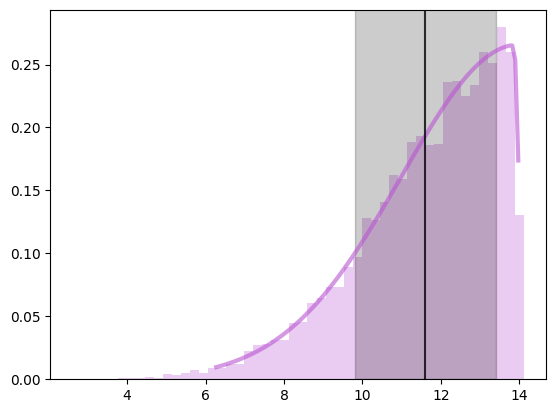

In [11]:
alpha = 0.05
a = -50
loc = 14
scale = 3
x1 = np.linspace(
    stats.skewnorm.ppf(0.01, a, loc=loc, scale=scale),
    stats.skewnorm.ppf(0.99, a, loc=loc, scale=scale),
    100,
)
skewed = stats.skewnorm.rvs(a, size=10000, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1)
ax.plot(
    x1,
    stats.skewnorm.pdf(x1, a, loc=loc, scale=scale),
    "r-",
    lw=3,
    alpha=0.6,
    color="mediumorchid",
)
ax.hist(
    skewed,
    density=True,
    histtype="stepfilled",
    bins=50,
    alpha=0.3,
    color="mediumorchid",
)
ax.axvline(np.mean(skewed), ymax=1, color="black", alpha=0.8)
rect = matplotlib.patches.Rectangle(
    (np.mean(skewed) - np.std(skewed), 0),
    2 * np.std(skewed),
    0.3,
    color="black",
    alpha=0.2,
)
ax.add_patch(rect)
plt.show()

In [12]:
samp_size = 10

results = []
for i in tqdm(range(10000)):
    # генерируем одинаковые выборки - они не должны отличаться
    sample1 = np.random.choice(skewed, samp_size)
    sample2 = np.random.choice(skewed, samp_size)
    _, pval = stats.ttest_ind(sample1, sample2)
    results.append(pval < alpha)

fpr = sum(results) / len(results)
print(f"FPR: {fpr:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.047


Полученное число — оценка доли ложных срабатываний при истинной H0. Ожидаемо около 0.05.


### Экспоненциальное распределение

Экспоненциальное распределение — сильная асимметрия и длинный хвост

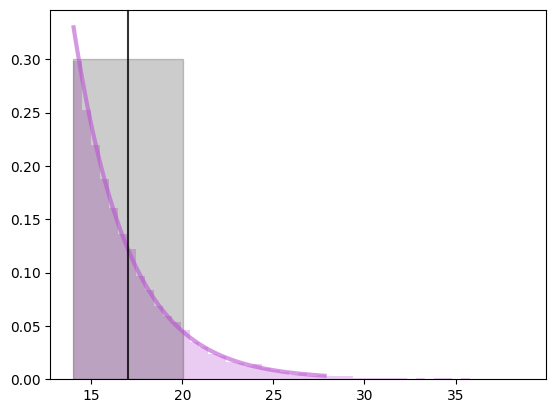

In [13]:
x1 = np.linspace(
    stats.expon.ppf(0.01, loc=loc, scale=scale),
    stats.expon.ppf(0.99, loc=loc, scale=scale),
    100,
)
exponential = stats.expon.rvs(size=10000, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1)
ax.plot(
    x1,
    stats.expon.pdf(x1, loc=loc, scale=scale),
    "r-",
    lw=3,
    alpha=0.6,
    color="mediumorchid",
)
ax.hist(
    exponential,
    density=True,
    histtype="stepfilled",
    bins=50,
    alpha=0.3,
    color="mediumorchid",
)
ax.axvline(np.mean(exponential), ymax=1, color="black", alpha=0.8)
rect = matplotlib.patches.Rectangle(
    (np.mean(exponential) - np.std(exponential), 0),
    2 * np.std(exponential),
    0.3,
    color="black",
    alpha=0.2,
)
ax.add_patch(rect)

plt.show()

In [14]:
samp_size = 10

results = []
for i in range(10000):
    sample1 = np.random.choice(exponential, samp_size)
    sample2 = np.random.choice(exponential, samp_size)
    _, pval = stats.ttest_ind(sample1, sample2)
    results.append(pval < alpha)

fpr = sum(results) / len(results)
print(f"FPR: {fpr:.3f}")

FPR: 0.044


Значения могут получаться отличными от 5%, но главное, чтобы они находились в доверительном интервале.


### Нормальное

Для нормального распределения t‑test — корректный инструмент, ожидаем близко к номинальному уровню 0.05.


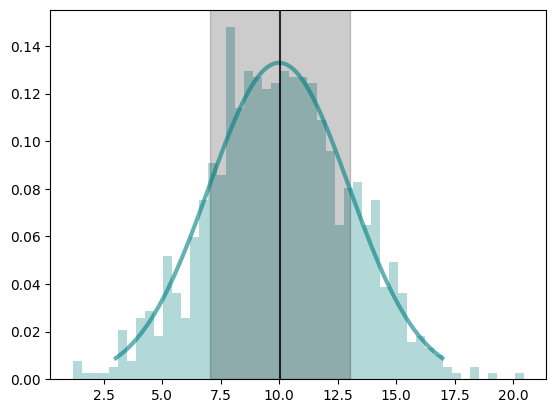

In [15]:
loc = 10
scale = 3
x2 = np.linspace(
    stats.norm.ppf(0.01, loc=loc, scale=scale),
    stats.norm.ppf(0.99, loc=loc, scale=scale),
    100,
)
normal = stats.norm.rvs(size=1000, loc=loc, scale=scale)
fig, ax = plt.subplots(1, 1)
ax.plot(
    x2, stats.norm.pdf(x2, loc=loc, scale=scale), "r-", lw=3, alpha=0.6, color="teal"
)
ax.hist(normal, density=True, histtype="stepfilled", bins=50, alpha=0.3, color="teal")
ax.axvline(np.mean(normal), ymax=1, color="black", alpha=0.8)
rect = matplotlib.patches.Rectangle(
    (np.mean(normal) - np.std(normal), 0),
    2 * np.std(normal),
    0.3,
    color="black",
    alpha=0.2,
)
ax.add_patch(rect)
plt.show()

In [16]:
samp_size = 10

results = []
for i in range(10000):
    sample1 = np.random.choice(normal, samp_size)
    sample2 = np.random.choice(normal, samp_size)
    _, pval = stats.ttest_ind(sample1, sample2)
    results.append(pval < 0.05)
fpr = sum(results) / len(results)

print(f"FPR: {fpr:.3f}")

FPR: 0.050


# 2. Mann Whitney

## 2.1 Для каких гипотез подходит

Критерий Манна–Уитни — это непараметрический тест для сравнения двух выборок. Критерий не предполагает нормальность распределений и работает с рангами наблюдений.

Важно понимать, что критерий Манна–Уитни **не проверяет равенство медиан/средних**. Его нулевая гипотеза:

$H_0$: распределения в группах A и B одинаковые.  
$H_1$: одно распределение сдвинуто относительно другого.

Интерпретация теста: он проверяет, больше ли вероятность того, что случайное наблюдение из одной группы больше, чем из другой.

Когда распределения имеют одинаковую форму и отличаются только сдвигом, тест фактически проверяет различие медиан. Но если формы распределений разные, интерпретация через медианы становится некорректной.

Просимулируем именно такую картинку - распределения одинаковы по форме и дисперсии, но одно из них "сдвинуто вправо"

In [45]:
data1 = 5 * np.random.randn(1000) + 50  # среднее 50, дисперсия 25
data2 = 5 * np.random.randn(1000) + 51  # среднее 51, дисперсия 25

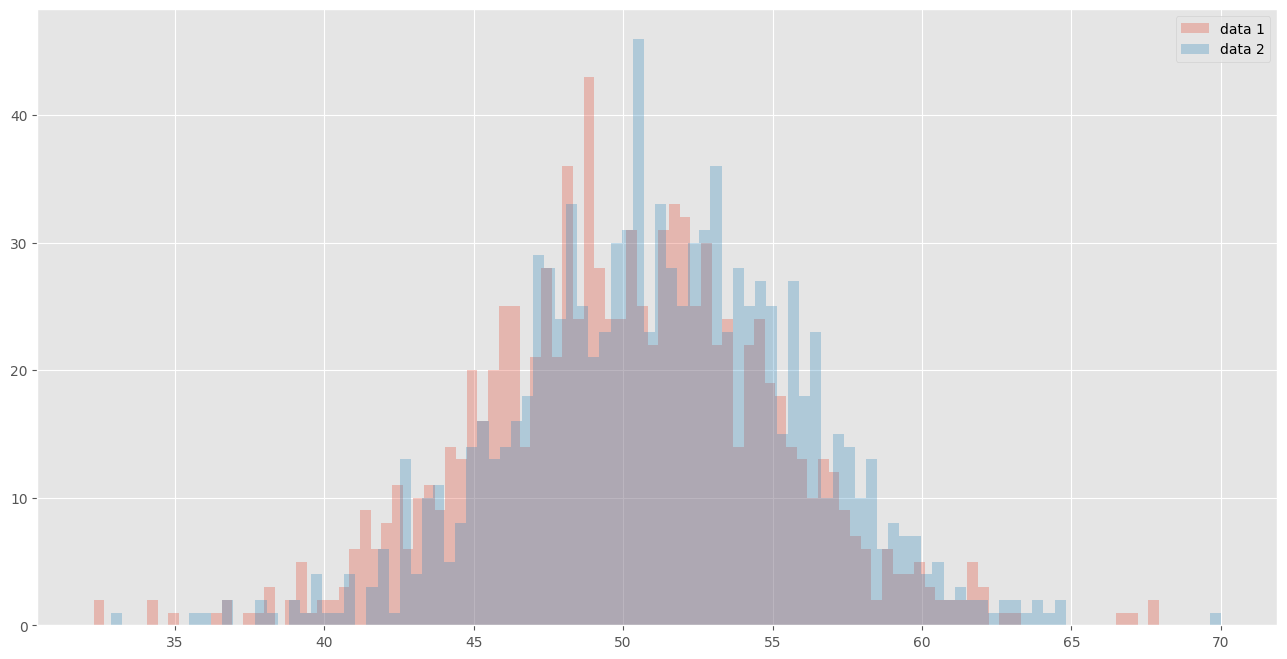

In [46]:
plt.figure(figsize=(16, 8))
plt.hist(data1, bins=100, alpha=0.3, label="data 1")
plt.hist(data2, bins=100, alpha=0.3, label="data 2")
plt.legend()
plt.show()

Применим критерий манна уитни - он ожидаемо отвергает гипотезу

In [47]:
stat, p = mannwhitneyu(data1, data2)
print(f"Statistics={stat}, p={p}")
alpha = 0.05
if p > alpha:
    print("Same distribution (fail to reject H0)")
else:
    print("Different distribution (reject H0)")

Statistics=432304.0, p=1.5853528050793405e-07
Different distribution (reject H0)


Просимулируем множество экспериментов, проверим FPR

In [48]:
num_tests = 10000

In [49]:
counter_acc = 0
stats_same = []
for i in tqdm(range(num_tests)):
    data1 = 5 * np.random.randn(1000) + 50
    data2 = 5 * np.random.randn(1000) + 50
    stat, p = mannwhitneyu(data1, data2)
    counter_acc += p > alpha
    stats_same.append(stat)

# второе число - доля принятия альтернативной гипотезы, при условии что различий нет
# это вероятность ошибки первого рода
fpr = (num_tests - counter_acc) / num_tests
print(f"FPR: {fpr:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

FPR: 0.049


Проверим и ошибку второго рода – мощность

In [50]:
counter_acc = 0
stats_diff = []
for i in tqdm(range(num_tests)):
    data1 = 5 * np.random.randn(1000) + 50
    data2 = 5 * np.random.randn(1000) + 51
    stat, p = mannwhitneyu(data1, data2)
    counter_acc += p > alpha
    stats_diff.append(stat)

power = (num_tests - counter_acc) / num_tests
print(f"Power: {power:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Power: 0.992


Ошибка II рода: H1 верна, но мы не отвергаем H0. Важна для мощности теста.



## 2.2 Когда тест может «ошибаться»

Критерий может показывать значимость, даже если медианы одинаковые, например:

- у групп одинаковые медианы, но разная дисперсия
- у одной группы тяжёлый хвост
- распределения имеют разную форму

В таких случаях тест реагирует не на сдвиг центра, а на различия в форме распределений. Приведем примеры, когда тест ошибется. 
*Хотя в реальности ошибется не тест, а аналитик, который его применяет, просто потому что критерий проверяет только гипотезу о сдвиге распределения :)*

Case 1: same median, different variance
median A: 0.013, median B: 0.166
p-value: 0.109620
----------------------------------------


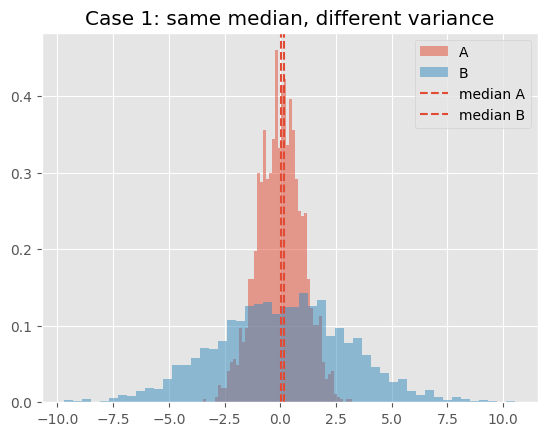

Case 2: same median, heavy tail
median A: 0.057, median B: 0.028
p-value: 0.104827
----------------------------------------


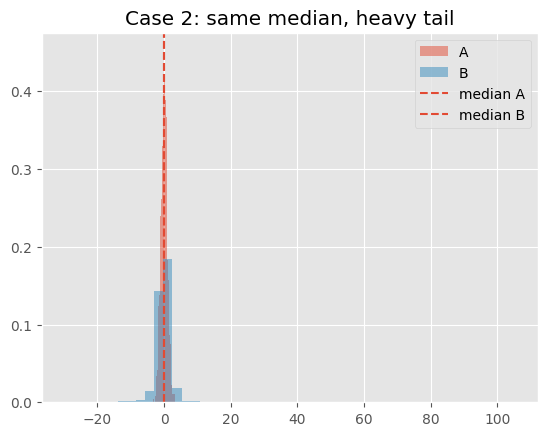

Case 3: same median, bimodal vs normal
median A: 0.016, median B: -0.021
p-value: 0.918376
----------------------------------------


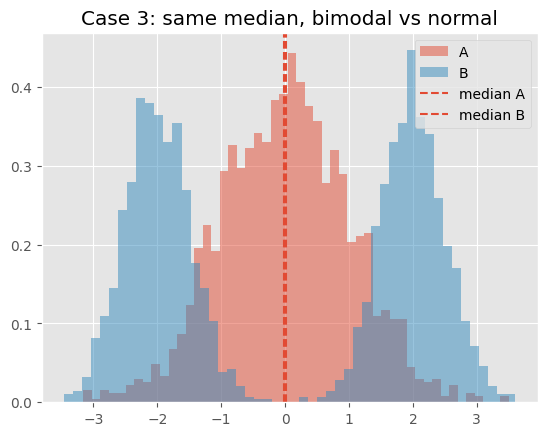

In [52]:
n = 2000


def run_case(a, b, title):
    stat, p = stats.mannwhitneyu(a, b, alternative="two-sided")
    print(f"{title}")
    print(f"median A: {np.median(a):.3f}, median B: {np.median(b):.3f}")
    print(f"p-value: {p:.6f}")
    print("-" * 40)

    plt.hist(a, bins=50, alpha=0.5, label="A", density=True)
    plt.hist(b, bins=50, alpha=0.5, label="B", density=True)
    plt.axvline(np.median(a), linestyle="--", label="median A")
    plt.axvline(np.median(b), linestyle="--", label="median B")
    plt.title(title)
    plt.legend()
    plt.show()


# 1. Одинаковая медиана, но разная дисперсия
a1 = np.random.normal(0, 1, n)
b1 = np.random.normal(0, 3, n)
run_case(a1, b1, "Case 1: same median, different variance")


# 2. Одинаковая медиана, но тяжёлый хвост
a2 = np.random.normal(0, 1, n)
b2 = np.random.standard_t(df=2, size=n)  # тяжёлые хвосты
run_case(a2, b2, "Case 2: same median, heavy tail")


# 3. Смесь распределений (разная форма, одинаковая медиана)
a3 = np.random.normal(0, 1, n)
b3 = np.concatenate(
    [np.random.normal(-2, 0.5, n // 2), np.random.normal(2, 0.5, n // 2)]
)
run_case(a3, b3, "Case 3: same median, bimodal vs normal")

Таким образом, нужно быть супер аккуратными в применении этого критерия на практике. Помним, что для бизнеса О1Р и О2Р это деньги и репутация (в случае раскатки чего-то, чего катить не стоило)

# 3. Сплитовалка

Покажем, как неправильное разбиение может дать ложный эффект.


In [31]:
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("2_sample_data.csv")

## Неслучайное разбиение

Разобьем очень странным способом. Половину выборки в одну группу, другую в другую

Это намеренно «плохой» сплит — систематическое смещение между группами.


In [32]:
data["treatment"] = [0] * (len(data) // 2) + [1] * (len(data) // 2 + 1)

Возьмем тритмент группу (тестовую) и контрольную группу и проведем между ними т-тест. В одинаковых группах эффекта бы не нашлось.


In [33]:
treated_group = data.loc[data["treatment"] == 1]["pnl_rub"]
control_group = data.loc[data["treatment"] == 0]["pnl_rub"]
stat, p = ttest_ind(treated_group, control_group)

print(f"Статистика: {stat}, p-value: {p}")

Статистика: 9.46761481578222, p-value: 3.1389278542200025e-21


Из‑за смещения можно получить «значимость», даже если эффекта нет.


## Случайное разбиение

Хеш‑сплит с солью: стабильная случайность и воспроизводимое разбиение.


In [34]:
from tqdm import tqdm_notebook
import hashlib
from sklearn.metrics import mutual_info_score
import statsmodels.api as sm


def ab_split(id, salt, control_group_size):
    """
    Returns 't' (for test) or 'c' (for control), based on the ID and salt.
    The control_group_size is a float, between 0 and 1, that sets how big the
    control group is.
    """

    test_id = str(id) + "-" + str(salt)
    test_id_digest = hashlib.md5(test_id.encode("ascii")).hexdigest()
    test_id_first_digits = test_id_digest[:6]
    test_id_final_int = int(test_id_first_digits, 16)
    ab_split = test_id_final_int / 0xFFFFFF

    if ab_split > control_group_size:
        return 0
    else:
        return 1

`salt` позволяет менять разбиение, не меняя исходные идентификаторы.


In [35]:
data["treatment_with_salt"] = data.uid.apply(lambda uid: ab_split(uid, "test-1", 0.5))

Проведем снова тест и увидим, что даже случайным разбиением группы по средним похожи (не отвергается 0 гипотеза о равенстве средних при уровне значимости 0.05)

In [37]:
treated_group = data.loc[data["treatment_with_salt"] == 1]["pnl_rub"]
control_group = data.loc[data["treatment_with_salt"] == 0]["pnl_rub"]
stat, p = ttest_ind(treated_group, control_group)

print(f"Статистика: {stat}, p-value: {p}")

Статистика: 1.496659096520079, p-value: 0.1344961617650426


При корректном сплите различий обычно нет — H0 не отвергается.


## A/A тесты для валидации качества сплита

AA-тест — это эксперимент, в котором обе группы на самом деле одинаковые. Мы случайно делим одну и ту же выборку на A и B и применяем статистический тест, как в обычном A/B-тесте.

Алгоритм:
1. Берём однородную выборку.
2. Случайно делим на группы A и B.
3. Считаем метрику.
4. Применяем статистический тест и получаем p-value.
5. Повторяем много раз.

Так как между группами нет реальной разницы, нулевая гипотеза всегда верна. В этом случае p-value имеет равномерное распределение:

$p \sim U(0, 1)$

Это следует из определения p-value.  
p-value — это вероятность получить наблюдаемое значение статистики или более экстремальное при верной $H_0$. Если нулевая гипотеза верна, то любое значение статистики допустимо и встречается в соответствии с её распределением. Тогда вероятность попасть в любой интервал по p-value одинакова, и распределение получается равномерным на отрезке от 0 до 1.

Мы отвергаем нулевую гипотезу, если:

$p < \alpha$

При равномерном распределении:

$P(p < \alpha) = \alpha$

Поэтому доля ложных срабатываний теста:

$FPR = \alpha$

TLDR идея метода A/A: мы искусственно делим одну и ту же популяцию на две группы, где эффекта **точно нет**. Если тест и пайплайн корректны, p‑values должны быть равномерны на [0,1], а доля ложных срабатываний близка к $\alpha$. Если равномерность ломается — значит проблема в разбиении, метрике, тесте или реализации.


###  Тест, который сходится

Пример АА теста, где сплит система дала качественное рандомное разбиение

  0%|          | 0/1000 [00:00<?, ?it/s]

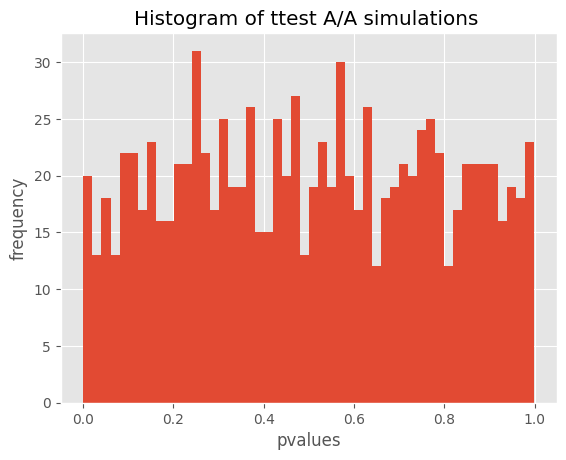

FPR: 4.50%


In [41]:
n = 100_000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame(
    {
        "s1": np.random.exponential(scale=1 / 0.001, size=n),
        "s2": np.random.exponential(scale=1 / 0.001, size=n),
    }
)

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df["s1"].sample(n_s, replace=False).values
    s2 = df["s2"].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])  # сохраняем pvalue

plt.hist(res, bins=50)
plt.style.use("ggplot")
plt.xlabel("pvalues")
plt.ylabel("frequency")
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
# FPR / Наблюдаемая O1Р
print(f"FPR: {sum(np.array(res) < 0.05) / simulations * 100:.2f}%")

Проверим равномерность p‑values через тест колмогорова смирнова. Он проверяет, что распределение принадлежит какому-то семейству распределений, в нашем случае - равномерному

In [42]:
from scipy.stats import kstest, uniform


def is_uniform(sample):
    # Perform the Kolmogorov-Smirnov test
    _, p_value = kstest(sample, uniform.cdf)

    return p_value


significance_level = 0.05
# Example usage
p_value = is_uniform(res)

print(
    f"p_value для гипотезы о том, что распределение равномерное: {p_value * 100:.2f}%"
)
if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value для гипотезы о том, что распределение равномерное: 66.35%
Uniform


## A/A-тест не сходится


Повторим ту же симуляцию, но добавим искусственный эффект 10% — сделаем наши группы заведомо разными


  0%|          | 0/1000 [00:00<?, ?it/s]

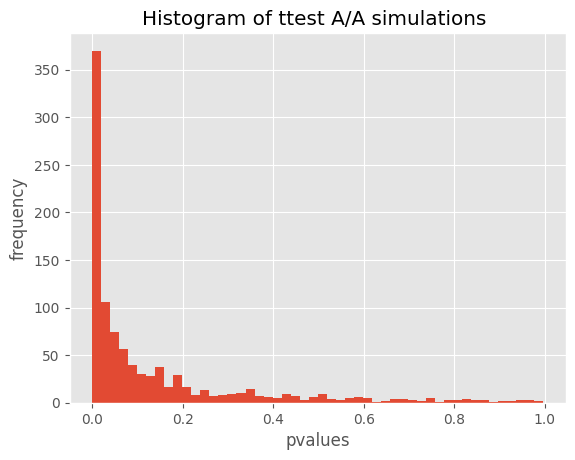

FPR: 51.00%


In [43]:
n = 100000
simulations = 1000
n_s = 1000
res = []

df = pd.DataFrame(
    {
        "s1": np.random.exponential(scale=1 / 0.001, size=n),
        "s2": np.random.exponential(scale=1 / 0.001, size=n)
        * 1.1,  # добавляем эффект 10%
    }
)

for i in tqdm(range(simulations)):
    s1 = df["s1"].sample(n_s, replace=False).values
    s2 = df["s2"].sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

plt.hist(res, bins=50)
plt.style.use("ggplot")
plt.xlabel("pvalues")
plt.ylabel("frequency")
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# FPR не сойдется
print(f"FPR: {sum(np.array(res) < 0.05) / simulations * 100:.2f}%")

Из‑за эффекта p‑values сдвигаются к малым значениям.


In [44]:
significance_level = 0.05
# Example usage
p_value = is_uniform(res)

print(
    f"p_value для гипотезы о том, что распределение равномерное: {p_value * 100:.2f}%"
)
if p_value > significance_level:
    print("Uniform")  # Sample distribution is likely uniform
else:
    print("Not Uniform")  # Sample distribution is not likely uniform

p_value для гипотезы о том, что распределение равномерное: 0.00%
Not Uniform


# Итог

- Стресстестим t‑test - работает на ненормальных распределениях
- Ошибки I и II рода и как они проявляются в симуляциях
- Показываем хеш‑сплит с солью как способ случайно и воспроизводимо посплитить
- Вводим A/A‑тесты как проверку корректности сплита: p‑values должны быть равномерными при отсутствии эффекта